In [1]:
%config Completer.use_jedi = False
import sys, IPython
print("IPython version:", IPython.__version__)
import jedi
print("Jedi version:", jedi.__version__)

IPython version: 9.8.0
Jedi version: 0.19.2


In [2]:
import tiledbsoma
import tiledbsoma.io
import anndata
import scipy.sparse
import numpy as np
import pandas as pd
import shutil
import os
import tiledb  

In [ ]:
# ============================================================
# 读取 TileDB SOMA 数据
# ============================================================
# 数据路径 (通过 preprocess_tiledb.py 转换)
SOMA_URI = "/fast/data/scTFM/ae/scBaseCount/tiledb_all/SRX19950187"

# 打开 SOMA Experiment
ctx = tiledbsoma.SOMATileDBContext()
exp = tiledbsoma.Experiment.open(SOMA_URI, context=ctx)

print(f"📂 SOMA URI: {SOMA_URI}")
print(f"📊 Experiment keys: {list(exp.keys())}")

📂 SOMA URI: /fast/data/scTFM/ae/scBaseCount/tiledb_all/SRX19950187
📊 Experiment keys: ['ms', 'obs']


In [ ]:
# ============================================================
# 1. 读取 obs (细胞元数据)
# ============================================================
obs_df = exp.obs.read().concat().to_pandas()
print(f"🔬 细胞数量: {len(obs_df)}")
print(f"📋 obs 列名: {list(obs_df.columns)}")
print()
obs_df.head(10)

🔬 细胞数量: 4060
📋 obs 列名: ['soma_joinid', 'obs_id', 'gene_count', 'umi_count', 'SRX_accession', 'n_genes', 'entrez_id', 'file_path', 'obs_count', 'lib_prep', 'tech_10x', 'cell_prep', 'organism', 'tissue', 'disease', 'perturbation', 'cell_line', 'czi_collection_id', 'czi_collection_name', 'sample_meta_available', 'split_label']



,soma_joinid,obs_id,gene_count,umi_count,SRX_accession,n_genes,entrez_id,file_path,obs_count,lib_prep,...,cell_prep,organism,tissue,disease,perturbation,cell_line,czi_collection_id,czi_collection_name,sample_meta_available,split_label
0,0,AAACCCAAGGTGCCTC,3751,11281.0,SRX19950187,3751,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
1,1,AAACCCAAGTTCTACG,5608,18588.0,SRX19950187,5608,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
2,2,AAACCCACAAGTGCAG,4297,12056.0,SRX19950187,4297,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
3,3,AAACCCACAGCACCCA,451,699.0,SRX19950187,451,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
4,4,AAACCCACAGTCTCTC,4415,14085.0,SRX19950187,4415,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
5,5,AAACCCACAGTGTACT,5322,16386.0,SRX19950187,5322,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
6,6,AAACCCAGTAACAAGT,3284,8647.0,SRX19950187,3284,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
7,7,AAACCCAGTTGCGAAG,4631,13765.0,SRX19950187,4631,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
8,8,AAACGAAAGATGGTCG,3298,9209.0,SRX19950187,3298,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0
9,9,AAACGAAGTGCTTCAA,568,1303.0,SRX19950187,568,27327012,gs://arc-scbasecount/2025-02-25/h5ad/GeneFull_...,4060,10x_Genomics,...,single_cell,Homo sapiens,embryo,unsure,In-vitro embryoid growth conditions,unsure,None,None,True,0


In [ ]:
# ============================================================
# 2. 查看 split_label 分布
# ============================================================
# split_label: 0=train, 1=val, 2=test, 3=OOD
split_counts = obs_df['split_label'].value_counts().sort_index()
split_names = {0: 'Train', 1: 'Val', 2: 'Test', 3: 'OOD'}
print("📊 Split Label 分布:")
for label, count in split_counts.items():
    print(f"   {label} ({split_names.get(label, 'Unknown')}): {count:,} cells")

In [ ]:
# ============================================================
# 3. 读取 var (基因元数据)
# ============================================================
var_df = exp.ms["RNA"].var.read().concat().to_pandas()
print(f"🧬 基因数量: {len(var_df)}")
print(f"📋 var 列名: {list(var_df.columns)}")
print()
var_df.head(10)

In [ ]:
# ============================================================
# 4. 读取 X 矩阵 (表达数据)
# ============================================================
# 注意：X 是 log1p(normalize_total(1e4)) 处理后的数据

# 获取 X 的 URI
x_uri = os.path.join(SOMA_URI, "ms", "RNA", "X", "data")
print(f"📁 X URI: {x_uri}")

# 读取特定细胞的数据 (例如前 100 个细胞)
n_cells = min(100, len(obs_df))
n_genes = len(var_df)

# 获取细胞 ID
cell_ids = obs_df['soma_joinid'].values[:n_cells]
print(f"📊 读取 {n_cells} 个细胞的表达数据...")

In [ ]:
# ============================================================
# 5. 读取 X 数据并转为 Dense 矩阵
# ============================================================
with tiledbsoma.open(x_uri, mode='r', context=ctx) as X:
    # 读取稀疏数据
    data = X.read(coords=(cell_ids, slice(None))).tables().concat()
    
    # 获取 COO 格式数据
    row_indices = data["soma_dim_0"].to_numpy()
    col_indices = data["soma_dim_1"].to_numpy()
    values = data["soma_data"].to_numpy()
    
    print(f"📊 稀疏数据点数: {len(values):,}")
    print(f"📊 非零元素占比: {len(values) / (n_cells * n_genes) * 100:.2f}%")

# 转换为 dense 矩阵
dense_matrix = np.zeros((n_cells, n_genes), dtype=np.float32)
local_rows = np.searchsorted(np.sort(cell_ids), row_indices)
dense_matrix[local_rows, col_indices] = values

print(f"✅ Dense 矩阵形状: {dense_matrix.shape}")
print(f"📊 矩阵数值范围: [{dense_matrix.min():.3f}, {dense_matrix.max():.3f}]")

In [ ]:
# ============================================================
# 6. 数据统计
# ============================================================
# 每个细胞检测到的基因数
genes_per_cell = (dense_matrix > 0).sum(axis=1)
print(f"📊 每细胞检测基因数:")
print(f"   Mean: {genes_per_cell.mean():.1f}")
print(f"   Median: {np.median(genes_per_cell):.1f}")
print(f"   Min: {genes_per_cell.min()}")
print(f"   Max: {genes_per_cell.max()}")

# 每个基因的表达细胞数
cells_per_gene = (dense_matrix > 0).sum(axis=0)
print(f"\n📊 基因表达分布:")
print(f"   表达基因数 (>0 in any cell): {(cells_per_gene > 0).sum()}")
print(f"   高表达基因 (>50% cells): {(cells_per_gene > n_cells * 0.5).sum()}")

In [ ]:
# ============================================================
# 7. 转换为 AnnData (可选)
# ============================================================
# 如果需要使用 Scanpy 进行分析，可以转换为 AnnData

# 创建 AnnData
adata = anndata.AnnData(
    X=scipy.sparse.csr_matrix(dense_matrix),
    obs=obs_df.iloc[:n_cells].copy(),
    var=var_df.copy()
)

# 设置 var_names
adata.var_names = var_df['soma_joinid'].astype(str).values

print(f"✅ AnnData 创建成功:")
print(f"   Shape: {adata.shape}")
print(adata)

In [ ]:
# ============================================================
# 8. 按 split_label 筛选数据
# ============================================================
# 例如：只读取训练集 (split_label=0) 的数据

def read_split_data(exp, split_label, max_cells=1000):
    """
    读取指定 split_label 的数据
    
    Args:
        exp: tiledbsoma.Experiment 对象
        split_label: 0=train, 1=val, 2=test, 3=OOD
        max_cells: 最多读取的细胞数
    
    Returns:
        x: (n_cells, n_genes) numpy array
        cell_ids: 细胞 ID 列表
    """
    # 筛选 obs
    query = exp.obs.read(
        value_filter=f"split_label == {split_label}",
        column_names=["soma_joinid"]
    ).concat()
    cell_ids = query["soma_joinid"].to_numpy()
    
    if len(cell_ids) > max_cells:
        cell_ids = np.random.choice(cell_ids, max_cells, replace=False)
    
    # 读取 X
    n_genes = exp.ms["RNA"].var.count
    x_uri = os.path.join(SOMA_URI, "ms", "RNA", "X", "data")
    
    with tiledbsoma.open(x_uri, mode='r', context=ctx) as X:
        data = X.read(coords=(np.sort(cell_ids), slice(None))).tables().concat()
        row_indices = data["soma_dim_0"].to_numpy()
        col_indices = data["soma_dim_1"].to_numpy()
        values = data["soma_data"].to_numpy()
    
    # 转换为 dense
    dense = np.zeros((len(cell_ids), n_genes), dtype=np.float32)
    sorted_ids = np.sort(cell_ids)
    local_rows = np.searchsorted(sorted_ids, row_indices)
    dense[local_rows, col_indices] = values
    
    return dense, cell_ids

# 测试：读取训练集数据
train_x, train_ids = read_split_data(exp, split_label=0, max_cells=500)
print(f"✅ 训练集数据形状: {train_x.shape}")

In [4]:
# ============================================================
# 10. 分析整个目录下 tissue 和 disease 的分布
# ============================================================
SOMA_URI = "/fast/data/scTFM/ae/scBaseCount/tiledb_all/"

import matplotlib.pyplot as plt
from collections import Counter
from tqdm import tqdm

# 获取所有子目录（每个是一个 SOMA experiment）
subdirs = [d for d in os.listdir(SOMA_URI) if os.path.isdir(os.path.join(SOMA_URI, d))]
print(f"📂 发现 {len(subdirs)} 个数据集")

# 收集所有 tissue 和 disease 信息
all_tissues = []
all_diseases = []
error_count = 0

ctx = tiledbsoma.SOMATileDBContext()

for subdir in tqdm(subdirs, desc="读取数据集"):
    exp_uri = os.path.join(SOMA_URI, subdir)
    try:
        with tiledbsoma.Experiment.open(exp_uri, context=ctx) as exp:
            # 读取 obs 中的 tissue 和 disease 列
            obs_data = exp.obs.read(column_names=["tissue", "disease"]).concat().to_pandas()
            all_tissues.extend(obs_data["tissue"].tolist())
            all_diseases.extend(obs_data["disease"].tolist())
    except Exception as e:
        error_count += 1
        continue

print(f"✅ 成功读取 {len(subdirs) - error_count} 个数据集")
print(f"❌ 失败: {error_count} 个")
print(f"📊 总细胞数: {len(all_tissues):,}")

# 统计分布
tissue_counts = Counter(all_tissues)
disease_counts = Counter(all_diseases)

print(f"\n🔬 Tissue 类型数: {len(tissue_counts)}")
print(f"🦠 Disease 类型数: {len(disease_counts)}")

📂 发现 14333 个数据集


读取数据集: 100%|██████████| 14333/14333 [18:43<00:00, 12.75it/s]


✅ 成功读取 14333 个数据集
❌ 失败: 0 个
📊 总细胞数: 103,950,776

🔬 Tissue 类型数: 72
🦠 Disease 类型数: 3170


📊 Tissue 分布 (Top 20):
--------------------------------------------------
 1. blood                          27,049,457 (26.02%)
 2. other                          11,058,752 (10.64%)
 3. brain                           9,459,786 ( 9.10%)
 4. lung                            5,916,775 ( 5.69%)
 5. bone marrow                     5,502,245 ( 5.29%)
 6. breast                          4,490,639 ( 4.32%)
 7. immune system                   3,760,589 ( 3.62%)
 8. skin of body                    3,413,469 ( 3.28%)
 9. eye                             2,741,717 ( 2.64%)
10. liver                           2,582,399 ( 2.48%)
11. heart                           2,167,889 ( 2.09%)
12. vasculature                     2,041,638 ( 1.96%)
13. pancreas                        1,626,708 ( 1.56%)
14. respiratory system              1,479,214 ( 1.42%)
15. embryo                          1,449,619 ( 1.39%)
16. skeletal system                 1,440,614 ( 1.39%)
17. colon                           1,397,637 (

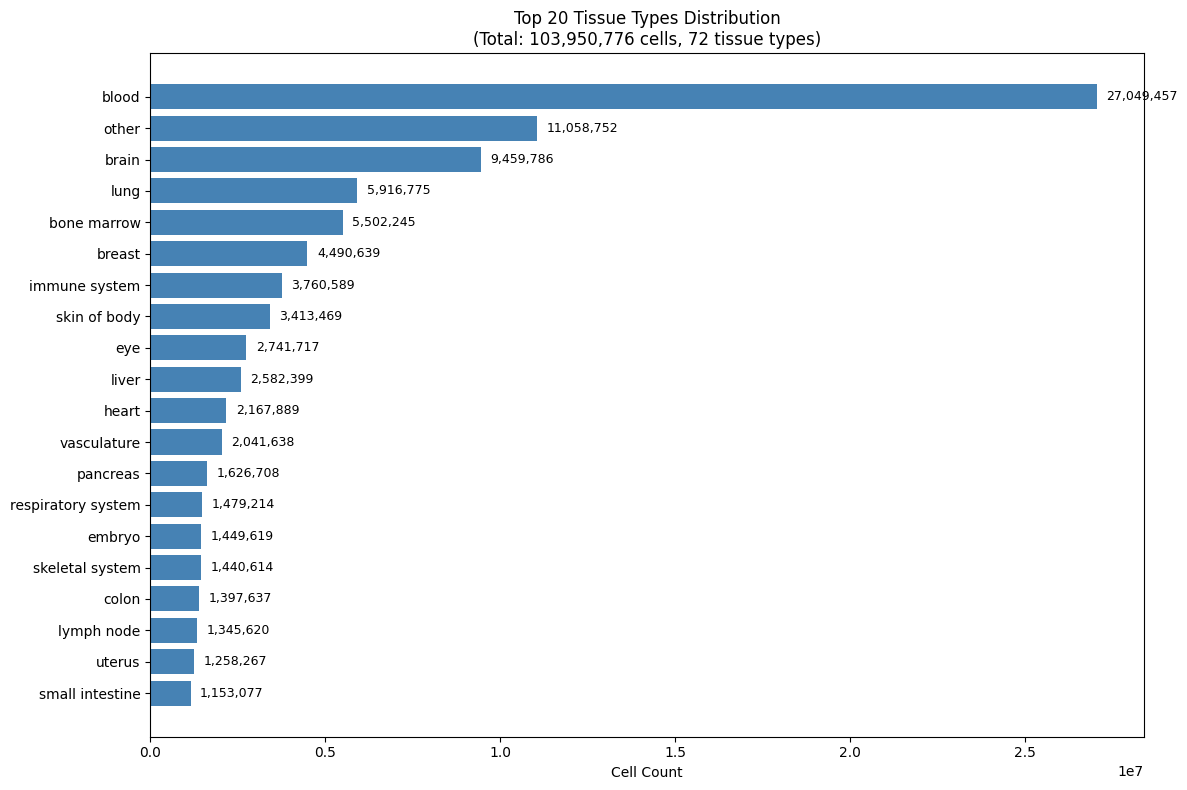

In [5]:
# ============================================================
# 10.1 可视化 Tissue 分布
# ============================================================
# 按数量排序
tissue_sorted = sorted(tissue_counts.items(), key=lambda x: x[1], reverse=True)

print("📊 Tissue 分布 (Top 20):")
print("-" * 50)
for i, (tissue, count) in enumerate(tissue_sorted[:20], 1):
    pct = count / len(all_tissues) * 100
    print(f"{i:2d}. {tissue:<30} {count:>10,} ({pct:>5.2f}%)")

# 绘制条形图
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(20, len(tissue_sorted))
tissues = [t[0] for t in tissue_sorted[:top_n]]
counts = [t[1] for t in tissue_sorted[:top_n]]

bars = ax.barh(range(top_n), counts, color='steelblue')
ax.set_yticks(range(top_n))
ax.set_yticklabels(tissues)
ax.invert_yaxis()
ax.set_xlabel('Cell Count')
ax.set_title(f'Top {top_n} Tissue Types Distribution\n(Total: {len(all_tissues):,} cells, {len(tissue_counts)} tissue types)')

# 添加数值标签
for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

📊 Disease 分布 (Top 20):
--------------------------------------------------
 1. unsure                              14,907,385 (14.34%)
 2. not specified                        6,282,568 ( 6.04%)
 3. none                                 2,397,526 ( 2.31%)
 4. COVID-19                             2,376,694 ( 2.29%)
 5. normal                               2,185,450 ( 2.10%)
 6. other                                1,505,807 ( 1.45%)
 7. healthy                              1,335,399 ( 1.28%)
 8. breast cancer                        1,232,354 ( 1.19%)
 9. multiple myeloma                     1,221,481 ( 1.18%)
10. control                                815,717 ( 0.78%)
11. autoimmune disease                     750,887 ( 0.72%)
12. melanoma                               695,908 ( 0.67%)
13. lung adenocarcinoma                    686,372 ( 0.66%)
14. SARS-CoV-2 infection                   669,131 ( 0.64%)
15. Trisomy 21 (Down's syndrome)           663,737 ( 0.64%)
16. glioblastoma          

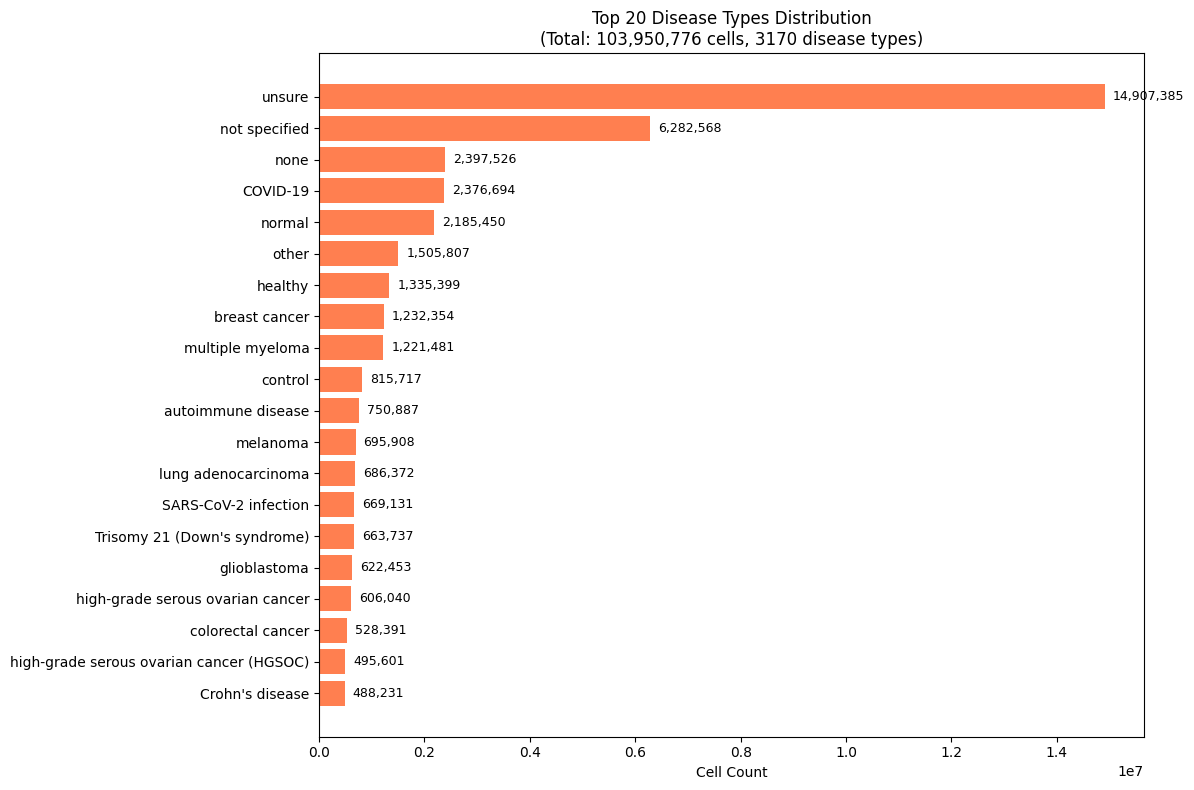

In [6]:
# ============================================================
# 10.2 可视化 Disease 分布
# ============================================================
# 按数量排序
disease_sorted = sorted(disease_counts.items(), key=lambda x: x[1], reverse=True)

print("📊 Disease 分布 (Top 20):")
print("-" * 50)
for i, (disease, count) in enumerate(disease_sorted[:20], 1):
    pct = count / len(all_diseases) * 100
    print(f"{i:2d}. {disease:<35} {count:>10,} ({pct:>5.2f}%)")

# 绘制条形图
fig, ax = plt.subplots(figsize=(12, 8))
top_n = min(20, len(disease_sorted))
diseases = [d[0] for d in disease_sorted[:top_n]]
counts = [d[1] for d in disease_sorted[:top_n]]

bars = ax.barh(range(top_n), counts, color='coral')
ax.set_yticks(range(top_n))
ax.set_yticklabels(diseases)
ax.invert_yaxis()
ax.set_xlabel('Cell Count')
ax.set_title(f'Top {top_n} Disease Types Distribution\n(Total: {len(all_diseases):,} cells, {len(disease_counts)} disease types)')

# 添加数值标签
for bar, count in zip(bars, counts):
    ax.text(bar.get_width() + max(counts)*0.01, bar.get_y() + bar.get_height()/2, 
            f'{count:,}', va='center', fontsize=9)

plt.tight_layout()
plt.show()

In [7]:
# ============================================================
# 10.3 完整分布统计表格
# ============================================================
# 创建 DataFrame 便于查看和导出

tissue_df = pd.DataFrame(tissue_sorted, columns=['Tissue', 'Count'])
tissue_df['Percentage'] = tissue_df['Count'] / tissue_df['Count'].sum() * 100
tissue_df['Percentage'] = tissue_df['Percentage'].round(2)

disease_df = pd.DataFrame(disease_sorted, columns=['Disease', 'Count'])
disease_df['Percentage'] = disease_df['Count'] / disease_df['Count'].sum() * 100
disease_df['Percentage'] = disease_df['Percentage'].round(2)

print("=" * 60)
print("📊 完整 Tissue 分布表")
print("=" * 60)
display(tissue_df)

print("\n" + "=" * 60)
print("📊 完整 Disease 分布表")
print("=" * 60)
display(disease_df)

📊 完整 Tissue 分布表


,Tissue,Count,Percentage
0,blood,27049457,26.02
1,other,11058752,10.64
2,brain,9459786,9.10
3,lung,5916775,5.69
4,bone marrow,5502245,5.29
...,...,...,...
67,head,5784,0.01
68,"""other""",5265,0.01
69,tendon of semitendinosus,3909,0.00
70,chest wall,3422,0.00



📊 完整 Disease 分布表


,Disease,Count,Percentage
0,unsure,14907385,14.34
1,not specified,6282568,6.04
2,none,2397526,2.31
3,COVID-19,2376694,2.29
4,normal,2185450,2.10
...,...,...,...
3165,"prostate cancer, COVID-19",5,0.00
3166,drug-resistant vaginal candidiasis,2,0.00
3167,RAS-mutated metastatic colorectal cancer,2,0.00
3168,antifungal immunity,1,0.00


In [ ]:
# ============================================================
# 9. 关闭连接
# ============================================================
exp.close()
print("✅ SOMA Experiment 已关闭")

## 数据说明

通过 `preprocess_tiledb.py` 转换的 TileDB SOMA 数据结构:

| 字段 | 说明 |
|------|------|
| `obs` | 细胞元数据，包含 `split_label` (0=train, 1=val, 2=test, 3=OOD) |
| `ms["RNA"].var` | 基因元数据，28231 个基因 |
| `ms["RNA"].X["data"]` | 表达矩阵，**已经过 normalize_total(1e4) + log1p 处理** |

### 数据处理流程 (preprocess_tiledb.py):
1. 读取原始 h5ad
2. 基因对齐到 28231 个目标基因
3. `sc.pp.filter_cells(min_genes=200)` - 过滤低质量细胞
4. `sc.pp.normalize_total(target_sum=1e4)` - 归一化
5. `sc.pp.log1p()` - 对数变换
6. 写入 TileDB SOMA